In [1]:
# 龙回头无脑修改版-Clone策略统计
import talib
import numpy as np
import pandas as pd
from time import time,localtime,strftime
import datetime
import csv
import json
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from jqdata import *
from jqlib.alpha101 import *
from dateutil import relativedelta

In [2]:
def get_previous_n_date(start, n):
    trade_days = get_trade_days(end_date=start, count=n)
    day = trade_days[0]
    return day

def get_next_n_date(start, n):
    trade_days = get_trade_days(start_date=start, end_date=start + datetime.timedelta(days=n*20))
    day = trade_days[n-1]
    return day

In [10]:
# 读取国债数据
guozhai_df = pd.read_excel (r'./guozhai.xlsx')

In [3]:
# 获取指数成分股权重值
index_id = "000300.XSHG"

start_date = datetime.date(2013,1,1)
start_date = get_next_n_date(start_date,2)
end_date = datetime.date(2022,10,1)

index_pe_list = []
date_list = []
index_close_list = []
guozhai_list = []
while start_date < end_date:
    index_weights_df = get_index_weights(index_id, date=start_date)
    symbol_list = index_weights_df.index.values

    pe_df = get_fundamentals(query(
              valuation.code, valuation.pe_ratio_lyr, valuation.pe_ratio
          ).filter(
              valuation.code.in_(symbol_list),
          ), date=start_date)

    # 计算指数pe
    index_return = 0
    for symbol in symbol_list:
        symbol_weight = index_weights_df.loc[index_weights_df.index == symbol]['weight'].values[0] / 100
        symbol_pe = pe_df.loc[pe_df.code == symbol]['pe_ratio'].values[0]

        symbol_weight_pe = (1 / symbol_pe) * symbol_weight
        index_return += symbol_weight_pe
    index_pe_list.append(1 / index_return)
    date_list.append(start_date.strftime("%Y-%m-%d"))
    
    price_df = get_price(index_id, start_date=start_date, end_date=start_date, frequency='1d', fields=['close'])
    index_close_list.append(price_df.close.values[0])
    
    start_date = start_date + relativedelta.relativedelta(months=1)
    start_date = start_date.replace(day=1)
    start_date = get_next_n_date(start_date, 2)


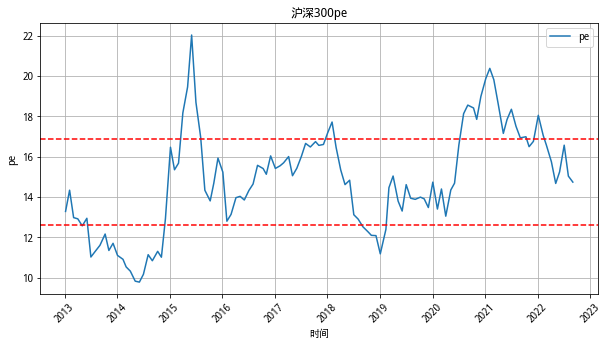

In [5]:

x_date = [datestr2num(i) for i in date_list]

# 画出分位线
twentieth_percentile = np.percentile(index_pe_list, 20)
eightieth_percentile = np.percentile(index_pe_list, 80)

plt.figure(figsize=(10,5))
plt.title("沪深300pe")
plt.xlabel("时间")
plt.xticks(rotation=45)
plt.ylabel("pe")
plt.plot_date(x_date, index_pe_list,'-',label="pe")

plt.axhline(twentieth_percentile,  color = 'r', linestyle='--')
plt.axhline(eightieth_percentile,  color = 'r', linestyle='--')

plt.legend()
plt.grid()

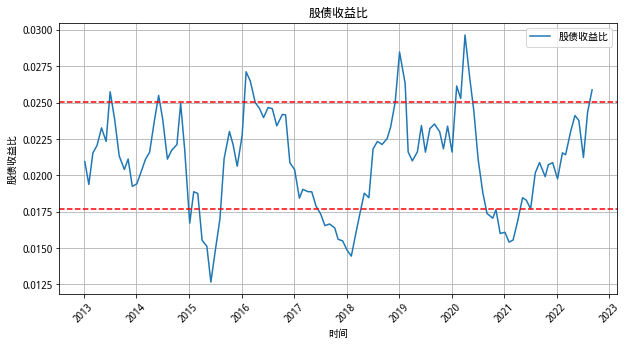

In [16]:
# 沪深300收益率(1/pe) 和 十年国债收益率之比
bond_earnings_yield_list = [guozhai_df.loc[guozhai_df['日期'] == _]['10y'].values[0] for _ in date_list]
BEER_list = [(1/index_pe_list[i]) / bond_earnings_yield_list[i] for i in range(len(bond_earnings_yield_list))]

# 画出分位线
twentieth_percentile = np.percentile(BEER_list, 20)
eightieth_percentile = np.percentile(BEER_list, 90)

plt.figure(figsize=(10,5))
plt.title("股债收益比")
plt.xlabel("时间")
plt.xticks(rotation=45)
plt.ylabel("股债收益比")
plt.plot_date(x_date, BEER_list,'-',label="股债收益比")

plt.axhline(twentieth_percentile,  color = 'r', linestyle='--')
plt.axhline(eightieth_percentile,  color = 'r', linestyle='--')

plt.legend()
plt.grid()

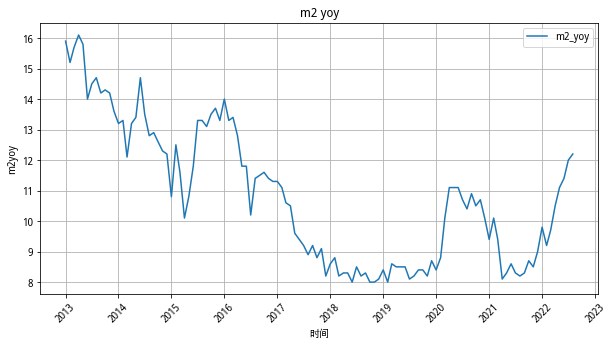

In [30]:
# 获取货币供应量M1 和 M2

q = query(macro.MAC_MONEY_SUPPLY_MONTH
    ).filter(macro.MAC_MONEY_SUPPLY_MONTH.stat_month >= "2013-01")
df = macro.run_query(q)
df = df.sort_values(by=['stat_month'])

m2_date = df.stat_month.values
m2_date = [_ + "-01" for _ in m2_date]
m2_yoy = df.m2_yoy.values
m2_date = [datestr2num(i) for i in m2_date]

m1_date = m2_date
m1_yoy = df.m1_yoy.values

plt.figure(figsize=(10,5))
plt.title("m2 yoy")
plt.xlabel("时间")
plt.xticks(rotation=45)
plt.ylabel("m2yoy")
plt.plot_date(m2_date, m2_yoy,'-',label="m2_yoy")
# plt.plot_date(x_date,data['high'],'-',color='r',label="最高价")
plt.legend()
plt.grid()

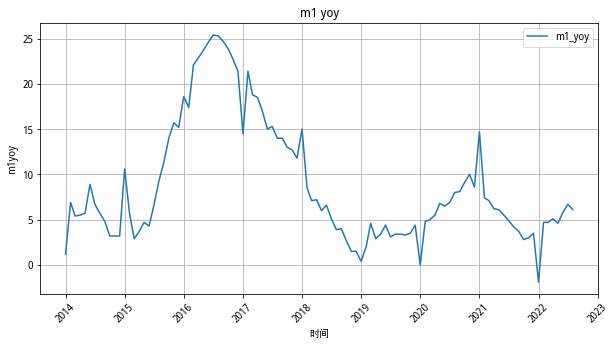

In [16]:
# 获取货币供应量m1

plt.figure(figsize=(10,5))
plt.title("m1 yoy")
plt.xlabel("时间")
plt.xticks(rotation=45)
plt.ylabel("m1yoy")
plt.plot_date(m1_date, m1_yoy,'-',label="m1_yoy")
# plt.plot_date(x_date,data['high'],'-',color='r',label="最高价")
plt.legend()
plt.grid()

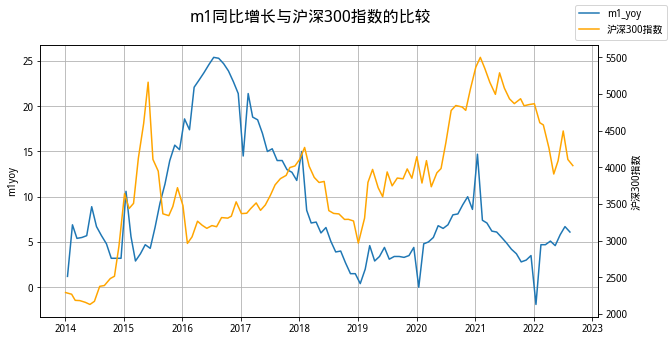

In [10]:

fig = plt.figure(figsize=(10,5))
fig.suptitle('m1同比增长与沪深300指数的比较', fontsize=16)
a1 = fig.add_subplot(111)
# a1 = fig.add_axes([0,0,1,1])
a1.plot_date(m1_date, m1_yoy,'-',label="m1_yoy")
a1.set_ylabel('m1yoy')

a2 = a1.twinx()
# a2.plot_date(m2_date, m2_yoy,'-',label="m2_yoy", color='orange')
# a2.set_ylabel('m2yoy')

a2.plot_date(x_date, index_close_list,'-',label="沪深300指数", color='orange')
a2.set_ylabel('沪深300指数')

fig.legend()
a1.grid()

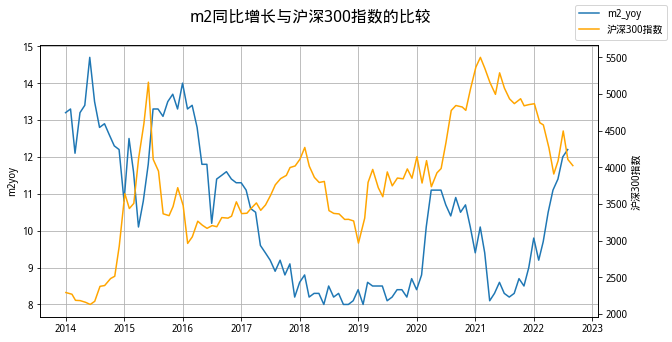

In [19]:

fig = plt.figure(figsize=(10,5))
fig.suptitle('m2同比增长与沪深300指数的比较', fontsize=16)
a1 = fig.add_subplot(111)
# a1 = fig.add_axes([0,0,1,1])

# a1.plot_date(m1_date, m1_yoy,'-',label="m1_yoy")
# a1.set_ylabel('m1yoy')
a1.plot_date(m2_date, m2_yoy,'-',label="m2_yoy")
a1.set_ylabel('m2yoy')

a2 = a1.twinx()
# a2.plot_date(m2_date, m2_yoy,'-',label="m2_yoy", color='orange')
# a2.set_ylabel('m2yoy')

a2.plot_date(x_date, index_close_list,'-',label="沪深300指数", color='orange')
a2.set_ylabel('沪深300指数')

fig.legend()
a1.grid()

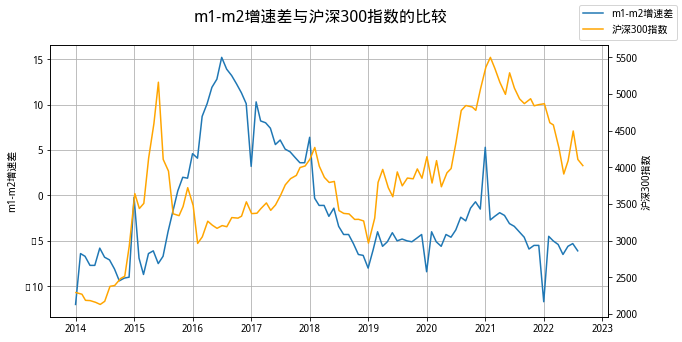

In [27]:

fig = plt.figure(figsize=(10,5))
fig.suptitle('m1-m2增速差与沪深300指数的比较', fontsize=16)
a1 = fig.add_subplot(111)
# a1 = fig.add_axes([0,0,1,1])

# a1.plot_date(m1_date, m1_yoy,'-',label="m1_yoy")
# a1.set_ylabel('m1yoy')
m1_m2_diff = m1_yoy - m2_yoy
a1.plot_date(m2_date, m1_m2_diff,'-',label="m1-m2增速差")
a1.set_ylabel('m1-m2增速差')

a2 = a1.twinx()
# a2.plot_date(m2_date, m2_yoy,'-',label="m2_yoy", color='orange')
# a2.set_ylabel('m2yoy')

a2.plot_date(x_date, index_close_list,'-',label="沪深300指数", color='orange')
a2.set_ylabel('沪深300指数')

fig.legend()
a1.grid()